In [27]:
!pip install imbalanced-learn
!pip install xgboost
!pip install graphviz

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE  # For class imbalance
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from xgboost import plot_tree

In [2]:
df = pd.read_csv("C:/Users/poula/Downloads/rawdata.csv")

# Quick check
print(df.head())
print(df.info())

# Check class imbalance
print(df['stroke'].value_counts(normalize=True))

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 e

In [3]:
# Convert multiple object columns to category
df[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']] = df[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']].astype('category')

# Check the data types
print(df.dtypes)

id                      int64
gender               category
age                   float64
hypertension            int64
heart_disease           int64
ever_married         category
work_type            category
Residence_type       category
avg_glucose_level     float64
bmi                   float64
smoking_status       category
stroke                  int64
dtype: object


In [4]:
# Select all category variables in this dataset and obtain the counts of each levels of those variables.
category_columns = df.select_dtypes(include='category').columns

for col in category_columns:
    print(f"\nCount of each level in '{col}':")
    counts = df[col].value_counts()
    for category, count in counts.items():
        print(f"{category}: {count}")


Count of each level in 'gender':
Female: 2994
Male: 2115
Other: 1

Count of each level in 'ever_married':
Yes: 3353
No: 1757

Count of each level in 'work_type':
Private: 2925
Self-employed: 819
children: 687
Govt_job: 657
Never_worked: 22

Count of each level in 'Residence_type':
Urban: 2596
Rural: 2514

Count of each level in 'smoking_status':
never smoked: 1892
Unknown: 1544
formerly smoked: 885
smokes: 789


In [5]:
#select all numerical variables in this dataset and obtain their summary statistics

numeric_columns = df.select_dtypes(include=['float64']).columns
print(df[numeric_columns].describe())

               age  avg_glucose_level          bmi
count  5110.000000        5110.000000  4909.000000
mean     43.226614         106.147677    28.893237
std      22.612647          45.283560     7.854067
min       0.080000          55.120000    10.300000
25%      25.000000          77.245000    23.500000
50%      45.000000          91.885000    28.100000
75%      61.000000         114.090000    33.100000
max      82.000000         271.740000    97.600000


In [6]:
#Obtain the count information for the values in the stroke, hypertension, and  heart_disease variables

def get_counts(df, column_name):
    # Convert the column_name type to int64, handling potential errors
    df[column_name] = pd.to_numeric(df[column_name], errors='raise').astype('int64')
    
    #calculate the value counts and sort by index which will be the column_name values.
    value_counts = df[column_name].value_counts().sort_index()
    print(f"Frequency counts for '{column_name}':\n{value_counts}\n")

get_counts(df,'stroke')
get_counts(df, 'hypertension')
get_counts(df, 'heart_disease')

Frequency counts for 'stroke':
stroke
0    4861
1     249
Name: count, dtype: int64

Frequency counts for 'hypertension':
hypertension
0    4612
1     498
Name: count, dtype: int64

Frequency counts for 'heart_disease':
heart_disease
0    4834
1     276
Name: count, dtype: int64



In [7]:
#Age 
#We are creating a new variable Age_temp_cat using the Age variable. The purpose of this new variable 
#is to help us in imputing the missing values of the bmi variable

#bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, float('inf')]
#labels = [0, 1, 2, 3, 4, 5, 6,7,8]
#bins = [0,15, 30, 45, 60, 75, float ('inf') ]
#labels = [0, 1, 2, 3, 4, 5]
#bins = [0, 20, 40, 60,  float('inf')]
#The bins above were used to play around with the data when determining the optimal bin values 
#for creating the new variable Age_temp_cat from Age

#Note that the minimum value for Age is 0.08 and the maximum value is 82

bins = [0, 20, 40, 60,  float('inf')]
labels = [0, 1, 2, 3]



df['Age_temp_cat'] = pd.cut(df['age'], bins=bins, labels=labels, right=False) 
df['Age_temp_cat'] = df['Age_temp_cat'].astype('category')

# Initialize and fit LabelEncoder
encoder = LabelEncoder()
df['Age_temp'] = encoder.fit_transform(df['Age_temp_cat'])
# Drop the intermediate 'Age_temp_cat' column
df.drop('Age_temp_cat', axis=1, inplace=True)
print (df.head(3))

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   

   stroke  Age_temp  
0       1         3  
1       1         3  
2       1         3  


In [8]:
#avg_glucose_level

#We are creating a new variable avg_glucose_level_temp_cat using the avg_glucose_level variable. The purpose of this new variable 
#is to help us in imputing the missing values of the bmi variable

#Note that the minimum value for avg_glucose_level is 55.12 and  the maximum value is 271.74

# Define the bins and labels
#bins = [50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, float('inf')]
#labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
#bins = [50, 90, 130, 170, 210, float('inf')]
#labels = [1, 2, 3, 4, 5]
#bins = [50, 100, 150, 200, float('inf')]
#labels = [1, 2, 3, 4]
#bins = [50, 120, 190, float('inf')]
#labels = [1, 2, 3]
#bins = [50, 150,float('inf')]
#labels = [1, 2]

#The bins above were used to play around with the data when determining the optimal bin values 
#for creating the new variable avg_glucose_level_temp_cat from avg_glucose_level

# Define the bins and labels
bins = [50, 120, 190, float('inf')]
labels = [1, 2, 3]

# Create the 'avg_glucose_level_temp' column using pd.cut
df['avg_glucose_level_temp_cat'] = pd.cut(df['avg_glucose_level'], bins=bins, labels=labels, right=False)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the categorical column
df['avg_glucose_level_temp'] = label_encoder.fit_transform(df['avg_glucose_level_temp_cat']) + 1 # +1 to match the original labels

df.drop('avg_glucose_level_temp_cat', axis=1, inplace=True)
# Print the DataFrame with the new categorical column
print(df.head(3))

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   

   stroke  Age_temp  avg_glucose_level_temp  
0       1         3                       3  
1       1         3                       3  
2       1         3                       1  


In [9]:
#Obtain the frequency counts of the newly created variables Age_temp and avg_glucose_level_temp
get_counts(df,'Age_temp')
get_counts(df, 'avg_glucose_level_temp')

Frequency counts for 'Age_temp':
Age_temp
0     966
1    1204
2    1564
3    1376
Name: count, dtype: int64

Frequency counts for 'avg_glucose_level_temp':
avg_glucose_level_temp
1    3991
2     589
3     530
Name: count, dtype: int64



In [10]:
#Gender variable
#Transform the Gender variable into a numerical variable using the label encoder method

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'gender' column
df['gender_encoded'] = label_encoder.fit_transform(df['gender'])
get_counts(df,'gender_encoded')

# Get the unique classes and their corresponding labels
class_labels = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Gender Mapping:")
for key, value in class_labels.items():
    print(f"{key}: {value}")

Frequency counts for 'gender_encoded':
gender_encoded
0    2994
1    2115
2       1
Name: count, dtype: int64

Gender Mapping:
Female: 0
Male: 1
Other: 2


In [11]:
#ever_married
#Transform the ever_married variable into a numerical variable using the label encoder method

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'ever_married' column
df['ever_married_encoded'] = label_encoder.fit_transform(df['ever_married'])

# Print the DataFrame with the new encoded column
print(df.head(3))

# Get the unique classes and their corresponding labels
class_labels = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("ever_married Mapping:")
for key, value in class_labels.items():
    print(f"{key}: {value}")

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   

   stroke  Age_temp  avg_glucose_level_temp  gender_encoded  \
0       1         3                       3               1   
1       1         3                       3               0   
2       1         3                       1               1   

   ever_married_encoded  
0                     1  
1                     1  
2                     1  
ever_married Mapping:
No: 0
Yes: 1


In [12]:
#Work type

#Transform the Work type variable into a numerical variable using the label encoder method

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'work_type' column
df['work_type_encoded'] = label_encoder.fit_transform(df['work_type'])

# Print the DataFrame with the new encoded column
print(df.head(3))



# Get the unique classes and their corresponding labels
class_labels = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("work_type Mapping:")
for key, value in class_labels.items():
    print(f"{key}: {value}")

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   

   stroke  Age_temp  avg_glucose_level_temp  gender_encoded  \
0       1         3                       3               1   
1       1         3                       3               0   
2       1         3                       1               1   

   ever_married_encoded  work_type_encoded  
0                     1                  2  
1                     1                  3  
2                     1       

In [13]:
children: 4
#Residence type

#Transform the Residence type variable into a numerical variable using the label encoder method

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Residence_type' column
df['Residence_type_encoded'] = label_encoder.fit_transform(df['Residence_type'])

# Print the DataFrame with the new encoded column
print(df.head(3))

# Get the unique classes and their corresponding labels
class_labels = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Residence_type Mapping:")
for key, value in class_labels.items():
    print(f"{key}: {value}")

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   

   stroke  Age_temp  avg_glucose_level_temp  gender_encoded  \
0       1         3                       3               1   
1       1         3                       3               0   
2       1         3                       1               1   

   ever_married_encoded  work_type_encoded  Residence_type_encoded  
0                     1                  2                       1  
1                     1    

In [14]:
#smoking status
#Transform the smoking status variable into a numerical variable using the label encoder method

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'smoking_status' column
df['smoking_status_encoded'] = label_encoder.fit_transform(df['smoking_status'])

# Print the DataFrame with the new encoded column
print(df.head(3))

# Get the unique classes and their corresponding labels
class_labels = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Residence_type Mapping:")
for key, value in class_labels.items():
    print(f"{key}: {value}")

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   

   stroke  Age_temp  avg_glucose_level_temp  gender_encoded  \
0       1         3                       3               1   
1       1         3                       3               0   
2       1         3                       1               1   

   ever_married_encoded  work_type_encoded  Residence_type_encoded  \
0                     1                  2                       1   
1                     1  

In [15]:
print (df.dtypes)

id                           int64
gender                    category
age                        float64
hypertension                 int64
heart_disease                int64
ever_married              category
work_type                 category
Residence_type            category
avg_glucose_level          float64
bmi                        float64
smoking_status            category
stroke                       int64
Age_temp                     int64
avg_glucose_level_temp       int64
gender_encoded               int64
ever_married_encoded         int32
work_type_encoded            int32
Residence_type_encoded       int32
smoking_status_encoded       int32
dtype: object


In [16]:
#  Imputes missing BMI values using grouped median based on other relevant variables in this dataframe
def impute_bmi_with_grouped_medians(df):
     # Identify the variables to group by
    grouping_columns = [
                         'gender_encoded',
                        'ever_married_encoded', 'work_type_encoded',
                        'Residence_type_encoded', 'smoking_status_encoded',
                        'Age_temp' , 'avg_glucose_level_temp'
                        ]
    # Calculate grouped median
    grouped_medians = df.groupby(grouping_columns)['bmi'].transform('median')

     # Impute missing values
    df['bmi'] = df['bmi'].fillna(grouped_medians)
    return (df)

# Impute missing BMI values
df = impute_bmi_with_grouped_medians(df)
print (df.head(3))

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   

       work_type Residence_type  avg_glucose_level    bmi   smoking_status  \
0        Private          Urban             228.69  36.60  formerly smoked   
1  Self-employed          Rural             202.21  29.65     never smoked   
2        Private          Rural             105.92  32.50     never smoked   

   stroke  Age_temp  avg_glucose_level_temp  gender_encoded  \
0       1         3                       3               1   
1       1         3                       3               0   
2       1         3                       1               1   

   ever_married_encoded  work_type_encoded  Residence_type_encoded  \
0                     1                  2                       1   
1                    

In [17]:
print (df.isnull().sum())

id                        0
gender                    0
age                       0
hypertension              0
heart_disease             0
ever_married              0
work_type                 0
Residence_type            0
avg_glucose_level         0
bmi                       4
smoking_status            0
stroke                    0
Age_temp                  0
avg_glucose_level_temp    0
gender_encoded            0
ever_married_encoded      0
work_type_encoded         0
Residence_type_encoded    0
smoking_status_encoded    0
dtype: int64


In [18]:
# Print rows with missing BMI values
missing_bmi_rows = df[df['bmi'].isnull()]
if not missing_bmi_rows.empty:
    print("Rows with missing BMI values:")
    print(missing_bmi_rows)
else:
    print("No missing BMI values found.")

Rows with missing BMI values:
         id  gender   age  hypertension  heart_disease ever_married work_type  \
19    25226    Male  57.0             0              1           No  Govt_job   
1102  18414  Female  23.0             0              0           No   Private   
1596  16593    Male  47.0             0              0           No   Private   
2752  42041  Female  38.0             0              0          Yes   Private   

     Residence_type  avg_glucose_level  bmi smoking_status  stroke  Age_temp  \
19            Urban             217.08  NaN        Unknown       1         2   
1102          Rural             193.22  NaN         smokes       0         1   
1596          Rural             237.17  NaN        Unknown       0         2   
2752          Rural             217.55  NaN         smokes       0         1   

      avg_glucose_level_temp  gender_encoded  ever_married_encoded  \
19                         3               1                     0   
1102                   

In [19]:
# imputing again without using the avg_glucose_level variable we used earlier
def impute_bmi_with_grouped_medians(df):
     # Identify the variables to group by
    grouping_columns = [
                         'gender_encoded',
                        'ever_married_encoded', 'work_type_encoded',
                        'Residence_type_encoded', 'smoking_status_encoded',
                        'Age_temp' 
                        ]
    # Calculate grouped means
    grouped_medians = df.groupby(grouping_columns)['bmi'].transform('median')

     # Impute missing values
    df['bmi'] = df['bmi'].fillna(grouped_medians)
    return (df)

# Impute missing BMI values
df = impute_bmi_with_grouped_medians(df)

In [20]:
print (df.isnull().sum())

id                        0
gender                    0
age                       0
hypertension              0
heart_disease             0
ever_married              0
work_type                 0
Residence_type            0
avg_glucose_level         0
bmi                       0
smoking_status            0
stroke                    0
Age_temp                  0
avg_glucose_level_temp    0
gender_encoded            0
ever_married_encoded      0
work_type_encoded         0
Residence_type_encoded    0
smoking_status_encoded    0
dtype: int64


In [21]:
# Check the columns of the dataframe
print(df.columns)

# Select only the encoded and numeric columns for X (drop non-encoded or non-numeric columns)
encoded_columns = [
    'gender_encoded', 
    'ever_married_encoded', 
    'work_type_encoded', 
    'Residence_type_encoded', 
    'smoking_status_encoded', 
    'Age_temp', 
    'avg_glucose_level_temp', 
    'bmi'  # Ensure bmi is numeric or imputed
]

# Ensure that only these encoded columns are included in X
X = df[encoded_columns]
y = df['stroke']

# Double-check if any non-numeric columns are still in X
print(X.dtypes)

# Now split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for balancing the dataset
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verify the shape after resampling
print(X_train_res.shape, y_train_res.shape)

# You can proceed with model training as usual



Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'Age_temp', 'avg_glucose_level_temp',
       'gender_encoded', 'ever_married_encoded', 'work_type_encoded',
       'Residence_type_encoded', 'smoking_status_encoded'],
      dtype='object')
gender_encoded              int64
ever_married_encoded        int32
work_type_encoded           int32
Residence_type_encoded      int32
smoking_status_encoded      int32
Age_temp                    int64
avg_glucose_level_temp      int64
bmi                       float64
dtype: object
(7778, 8) (7778,)


Accuracy: 0.7074
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.70      0.82       972
           1       0.12      0.76      0.20        50

    accuracy                           0.71      1022
   macro avg       0.55      0.73      0.51      1022
weighted avg       0.94      0.71      0.79      1022

ROC AUC Score: 0.7324


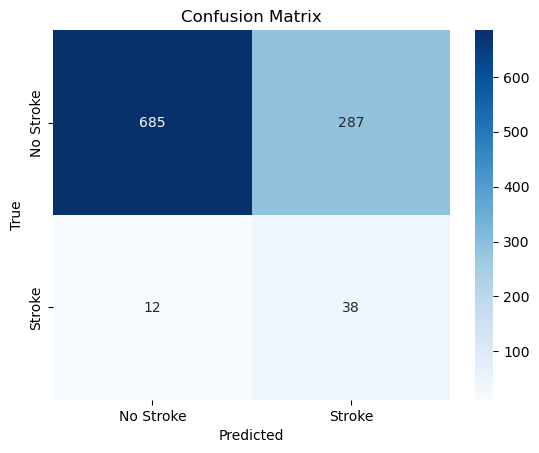

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
lr = LogisticRegression(random_state=42)
lr.fit(X_train_res, y_train_res)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc:.4f}")
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Stroke", "Stroke"], yticklabels=["No Stroke", "Stroke"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("ROC AUC Score:", roc_auc)


Accuracy: 0.7348336594911937
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.73      0.84       972
           1       0.13      0.78      0.22        50

    accuracy                           0.73      1022
   macro avg       0.56      0.76      0.53      1022
weighted avg       0.94      0.73      0.81      1022

ROC AUC Score: 0.8023456790123455


Accuracy (without SMOTE): 0.9511
Classification Report (without SMOTE):
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

ROC AUC Score (without SMOTE): 0.5000
Accuracy (with SMOTE): 0.7074
Classification Report (with SMOTE):
               precision    recall  f1-score   support

           0       0.98      0.70      0.82       972
           1       0.12      0.76      0.20        50

    accuracy                           0.71      1022
   macro avg       0.55      0.73      0.51      1022
weighted avg       0.94      0.71      0.79      1022

ROC AUC Score (with SMOTE): 0.7324


c:\Users\poula\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\poula\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\poula\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

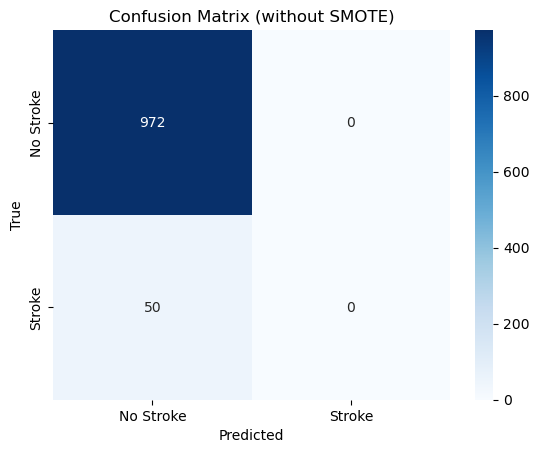

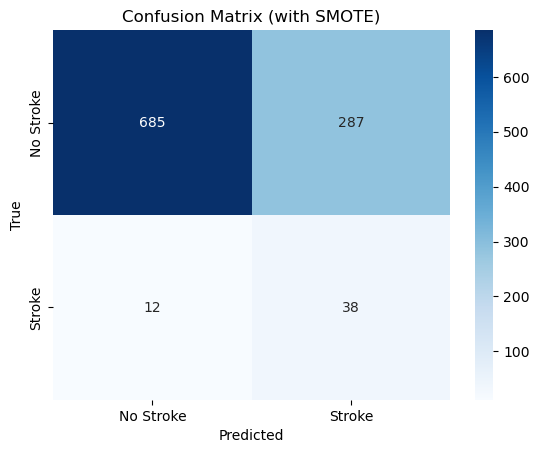

In [24]:
# Importing Logistic Regression and other necessary libraries for evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Train a Logistic Regression model without SMOTE (on imbalanced dataset)
lr_no_smote = LogisticRegression(random_state=42)
lr_no_smote.fit(X_train, y_train)

# Predict on the test set (without SMOTE)
y_pred_no_smote = lr_no_smote.predict(X_test)

# Evaluate the model without SMOTE
accuracy_no_smote = accuracy_score(y_test, y_pred_no_smote)
print(f"Accuracy (without SMOTE): {accuracy_no_smote:.4f}")

# Classification report for more detailed evaluation (without SMOTE)
class_report_no_smote = classification_report(y_test, y_pred_no_smote)
print("Classification Report (without SMOTE):\n", class_report_no_smote)

# ROC AUC Score to measure performance (without SMOTE)
roc_auc_no_smote = roc_auc_score(y_test, y_pred_no_smote)
print(f"ROC AUC Score (without SMOTE): {roc_auc_no_smote:.4f}")


# Train a Logistic Regression model with SMOTE (on balanced dataset)
lr_with_smote = LogisticRegression(random_state=42)
lr_with_smote.fit(X_train_res, y_train_res)

# Predict on the test set (with SMOTE)
y_pred_with_smote = lr_with_smote.predict(X_test)

# Evaluate the model with SMOTE
accuracy_with_smote = accuracy_score(y_test, y_pred_with_smote)
print(f"Accuracy (with SMOTE): {accuracy_with_smote:.4f}")

# Classification report for more detailed evaluation (with SMOTE)
class_report_with_smote = classification_report(y_test, y_pred_with_smote)
print("Classification Report (with SMOTE):\n", class_report_with_smote)

# ROC AUC Score to measure performance (with SMOTE)
roc_auc_with_smote = roc_auc_score(y_test, y_pred_with_smote)
print(f"ROC AUC Score (with SMOTE): {roc_auc_with_smote:.4f}")

# Confusion Matrix for comparison (both with and without SMOTE)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix without SMOTE
cm_no_smote = confusion_matrix(y_test, y_pred_no_smote)
sns.heatmap(cm_no_smote, annot=True, fmt="d", cmap="Blues", xticklabels=["No Stroke", "Stroke"], yticklabels=["No Stroke", "Stroke"])
plt.title("Confusion Matrix (without SMOTE)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Confusion Matrix with SMOTE
cm_with_smote = confusion_matrix(y_test, y_pred_with_smote)
sns.heatmap(cm_with_smote, annot=True, fmt="d", cmap="Blues", xticklabels=["No Stroke", "Stroke"], yticklabels=["No Stroke", "Stroke"])
plt.title("Confusion Matrix (with SMOTE)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [25]:
# Compute scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Train XGBoost with class imbalance handling
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb.predict(X_test)

# Evaluate
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])

print(f"Accuracy (XGBoost with scale_pos_weight): {accuracy_xgb:.4f}")
print("Classification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))
print(f"ROC AUC Score (XGBoost): {roc_auc_xgb:.4f}")


Accuracy (XGBoost with scale_pos_weight): 0.8777
Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.96      0.91      0.93       972
           1       0.12      0.24      0.16        50

    accuracy                           0.88      1022
   macro avg       0.54      0.58      0.55      1022
weighted avg       0.92      0.88      0.90      1022

ROC AUC Score (XGBoost): 0.7303


c:\Users\poula\miniconda3\envs\dsi_participant\lib\site-packages\xgboost\core.py:158: UserWarning: [18:11:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Scale Pos Weight: 19.5427
Accuracy (XGBoost with scale_pos_weight): 0.8777
Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.96      0.91      0.93       972
           1       0.12      0.24      0.16        50

    accuracy                           0.88      1022
   macro avg       0.54      0.58      0.55      1022
weighted avg       0.92      0.88      0.90      1022

ROC AUC Score (XGBoost): 0.7303


c:\Users\poula\miniconda3\envs\dsi_participant\lib\site-packages\xgboost\core.py:158: UserWarning: [18:11:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


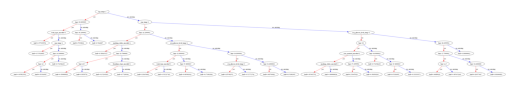

In [26]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from xgboost import XGBClassifier

# Compute scale_pos_weight based on class distribution in the training set
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Scale Pos Weight: {scale_pos_weight:.4f}")

# Initialize XGBoost classifier with class imbalance handling
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight, 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model's performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

# Print evaluation results
print(f"Accuracy (XGBoost with scale_pos_weight): {accuracy_xgb:.4f}")
print("Classification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))
print(f"ROC AUC Score (XGBoost): {roc_auc_xgb:.4f}")

# Plot the first tree from the trained XGBoost model
xgb.plot_tree(xgb_model, num_trees=0)  # 'num_trees=0' refers to the first tree in the model
plt.show()


In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
import graphviz
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Compute scale_pos_weight based on class distribution in the training set
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Scale Pos Weight: {scale_pos_weight:.4f}")

# Initialize XGBoost classifier with class imbalance handling
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight, 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model's performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

# Print evaluation results
print(f"Accuracy (XGBoost with scale_pos_weight): {accuracy_xgb:.4f}")
print("Classification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))
print(f"ROC AUC Score (XGBoost): {roc_auc_xgb:.4f}")

# Export the first tree to a dot file
xgb_model.get_booster().dump_model('xgb_tree.dot', with_stats=True)

# Visualize the tree using Graphviz
with open('xgb_tree.dot') as f:
    dot_graph = f.read()

# Render the tree using Graphviz
graphviz.Source(dot_graph)
